In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sympy as sy

In [17]:
def arrayPlot(array,vmin=0,vmax=None):
    """A python version of the ArrayPlot[] function in Mathematica"""
    fig, ax = plt.subplots()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(array,cmap='Greys',vmin=vmin,vmax=vmax)
    plt.show()
def runMCmovie(kT,J,B,MCstepFunction, ax, config):
    """a python version of the runMCmovie function"""
    nSize = 10
    checkerboardConfig = np.array([[(-1)**(row+col) for row in range(nSize)] for col in range(nSize)])
    newConfig = config.copy()
    trajectory = []
    for i in range(1500):
        newConfig = MCstepFunction(kT,J,B,newConfig)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        arrayplot = [ax.imshow(newConfig,cmap='Greys',
                               vmin=-1,vmax=1, animated=True)]
        # print(arrayplot)
        trajectory.append(arrayplot)
    return trajectory #a list of arrayplot outputs

In [3]:
def netMagnetization(config):
    """Python version of the second netMagnetization[] function Schrier writes
    automatically includes summation over all levels of the array"""
    return np.sum(config)
def netMagnetizationPerSpin(config):
  """Python version of net magnetization function"""
  return netMagnetization(config)/len(config)**2
def runMC(kT, J, B, nEquil, nDataCol, sampleInterval, config, MCstepFunction, energyFunction):
    """function to run the Ising model MC simulation and collectsamples"""
    Esamples = []
    Msamples = []
    newConfig = config.copy()
    for i in range(nEquil):
        newConfig = MCstepFunction(kT, J, B, newConfig)
    for i in range(nDataCol):
        newConfig = MCstepFunction(kT, J, B, newConfig)
        if i % sampleInterval == 0:
            Esamples.append(energyFunction(newConfig,J,B))
            Msamples.append(abs(netMagnetizationPerSpin(newConfig)))
    Esamples = np.array(Esamples)
    Msamples = np.array(Msamples)
    return [Esamples.mean()/len(config)**2, # Mean Energy per spin
           Esamples.var()*len(config)**2/(kT**2), # MS per spin
           Msamples.mean(), # Average net magnetization per spin
           np.var(Esamples)/(len(config)*kT**2),
           newConfig] # The Final configuration

In [4]:
def energyIsing2D(config,J,B):
    """
    Function for calculating the energy of an Ising Model.
    Requires a config (the Ising Model in question), a value of J (interaction parameter)
    and a value for B (external field parameter)
    """
    energyB,energyJ = 0,0 # Initializes local variables
    for row in range(len(config)): # Loop over rows
        for col in range(len(config)): # Simultaneously loop over columns
            energyB += B*config[row,col]
            if row>0: # Up
                J = -1 
                energyJ += J*config[row-1,col]*config[row,col] # Interior
            else:
                J = -1 
                energyJ += J*config[len(config)-1,col]*config[row,col] # Periodic boundary conditions
            if row<len(config)-1: # Down
                J = -1 
                energyJ += J*config[row+1,col]*config[row,col] # Interior
            else:
                J = -1 
                energyJ += J*config[0,col]*config[row,col] # Periodic boundary conditions
                # Alternating interactions within rows
            if( col % 2 == 1):
                J_right = -1
                J_left = 1
            else:
                J_right = 1
                J_left = -1

            if col>0: # Left
                energyJ += J_left*config[row,col-1]*config[row,col] # Interior
            else:
                energyJ += J_left*config[row,len(config)-1]*config[row,col] # Periodic boundary conditions
            if col<len(config)-1: # right
                energyJ += J_right*config[row,col+1]*config[row,col] # Interior
            else:
                energyJ += J_right*config[row,0]*config[row,col] # Periodic boundary conditions
    return energyB + energyJ/2 # Removes double counting
def MCstepPBC(kT,J,B,config):
    """MC step for Periodic Ising Model"""
    #interactions are predetermined from problem! 
    newConfig = config.copy()
    row,col = np.random.randint(0,len(config),2)
    Estart = config[row,col]*B
    if row>0: # Up
        J = -1 
        Estart += J*config[row-1,col]*config[row,col] # Interior
    else:
        J = -1 
        Estart += J*config[len(config)-1,col]*config[row,col] # Periodic boundary conditions
    if row<len(config)-1: # Down
        J = -1 
        Estart += J*config[row+1,col]*config[row,col] # Interior
    else:
        J = -1 
        Estart += J*config[0,col]*config[row,col] # Periodic boundary conditions
        # Alternating interactions within rows
    
    if( col % 2 == 1):
        J_right = -1
        J_left = 1
    else:
        J_right = 1
        J_left = -1

    if col>0: # Left
        Estart += J_left*config[row,col-1]*config[row,col] # Interior
    else:
        Estart += J_left*config[row,len(config)-1]*config[row,col] # Periodic boundary conditions
    if col<len(config)-1: # right
        Estart += J_right*config[row,col+1]*config[row,col] # Interior
    else:
        Estart += J_right*config[row,0]*config[row,col] # Periodic boundary conditions
    Eend = -Estart

    if Eend < Estart: #did energy decrease?
      newConfig[row,col] *= -1 # Then flip the spin
    else:
      if np.all(np.random.random() <= np.exp(-(Eend-Estart)/kT)): # If a random number is less than the probability
        newConfig[row,col] *= -1 # Then flip the spin

    return newConfig # Return the potentially altered array

In [5]:
Stripes = np.zeros((10, 10))
# Fill alternating columns with -1 and 1
Stripes[:,::4] = -1 
Stripes[:,1::4] = -1  
Stripes[:,2::4] = 1   
Stripes[:,3::4] = 1   
print(Stripes)
lattice_size = 10
checkerboardConfig = np.array([[(-1)**(row+col) for row in range(lattice_size)] for col in range(10)])
array__negative = np.full((10, 10), -1)
array__positive = np.full((10, 10), 1)
kbT_values = np.linspace(1, 4, 20)

[[-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.]
 [-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.]]


In [6]:
kT_values = np.linspace(1, 4, 20)
nEquil = 1000000
data_collect = 20000
sample_size = 1000

mean_energy_spin = []
mc_spin = []
magnet_suspect = []
heat_capacity = []
configurations = []
for Temp in kT_values:
    results = runMC(Temp, -1, 1, nEquil, data_collect, sample_size, Stripes, MCstepPBC, energyIsing2D)
    mean_energy_spin.append(results[0]) 
    magnet_suspect.append(results[1]) 
    mc_spin.append(results[2]) 
    heat_capacity.append(results[3])
    configurations.append(results[4])

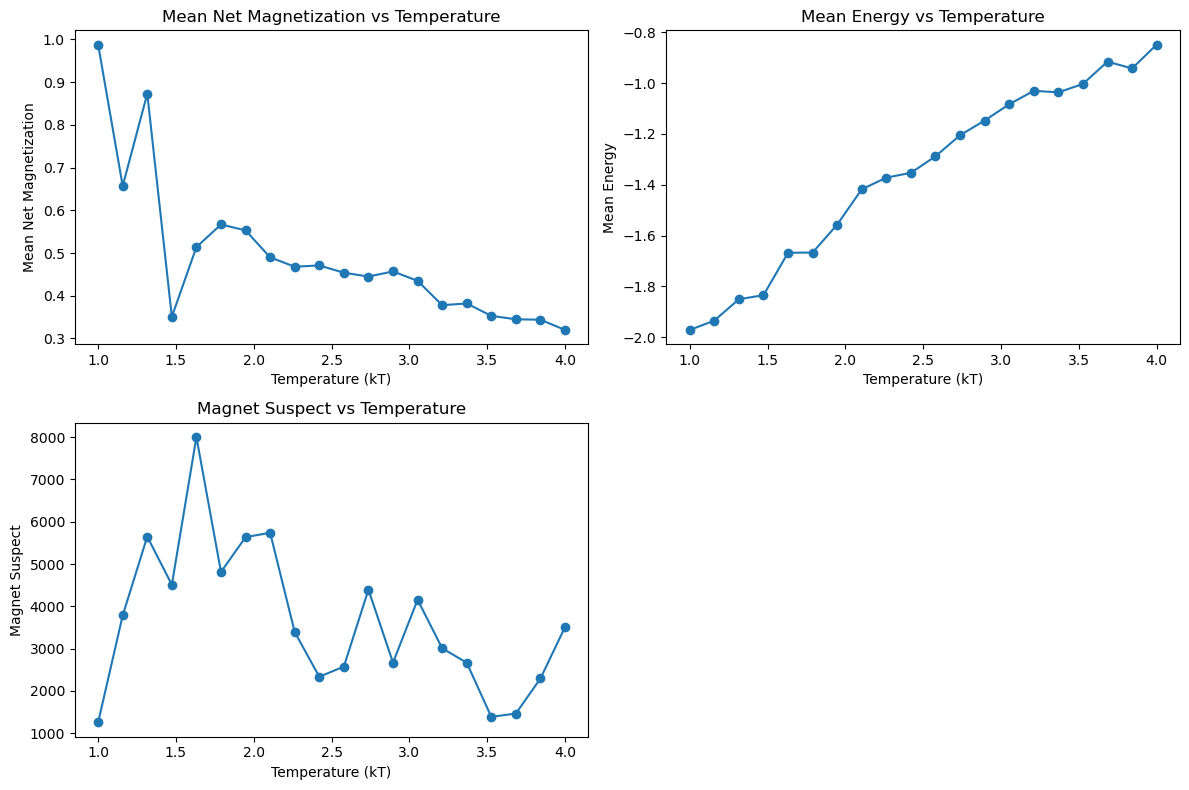

In [10]:
# Plot the results using Seaborn
import seaborn as sns
plt.figure(figsize=(12,8))

plt.subplot(2, 2, 1)
plt.plot(kT_values, mc_spin, marker='o')
plt.title('Mean Net Magnetization vs Temperature')
plt.xlabel('Temperature (kT)')
plt.ylabel('Mean Net Magnetization')

plt.subplot(2, 2, 2)
plt.plot(kT_values, mean_energy_spin, marker='o')
plt.title('Mean Energy vs Temperature')
plt.xlabel('Temperature (kT)')
plt.ylabel('Mean Energy')

plt.subplot(2, 2, 3)
plt.plot(kT_values, magnet_suspect, marker='o')
plt.title('Magnet Suspect vs Temperature')
plt.xlabel('Temperature (kT)')
plt.ylabel('Magnet Suspect')


plt.tight_layout()
plt.show()

Text(0, 0.5, 'Heat Capacity')

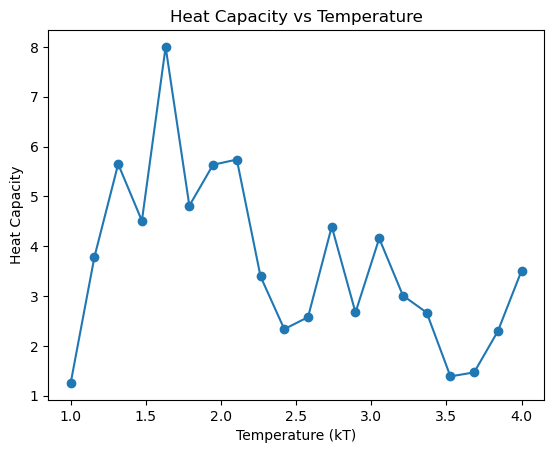

In [12]:
plt.plot(kT_values, heat_capacity, marker='o')
plt.title('Heat Capacity vs Temperature')
plt.xlabel('Temperature (kT)')
plt.ylabel('Heat Capacity')

ValueError: minvalue must be less than or equal to maxvalue

<Figure size 640x480 with 1 Axes>

None


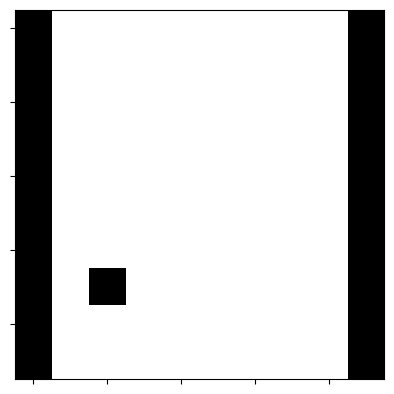

None


ValueError: minvalue must be less than or equal to maxvalue

<Figure size 640x480 with 1 Axes>

None


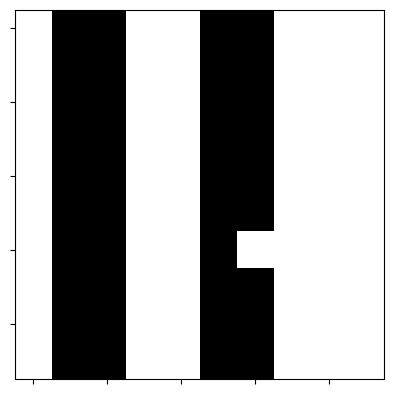

None


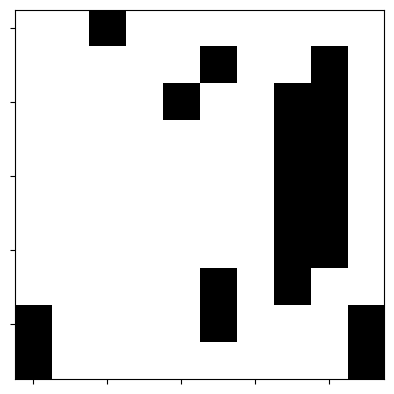

None


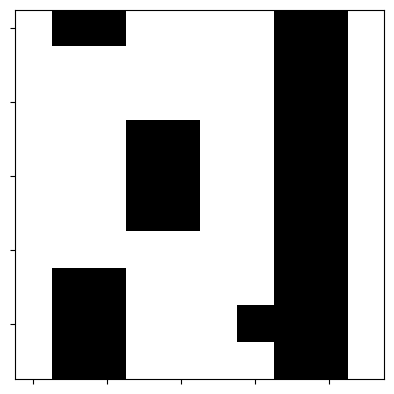

None


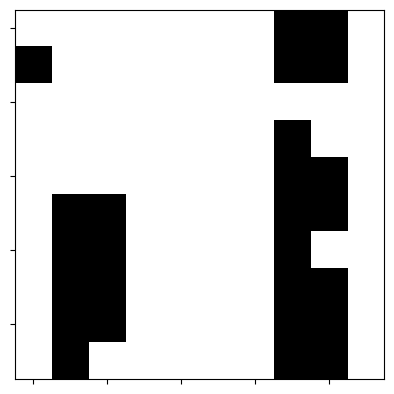

None


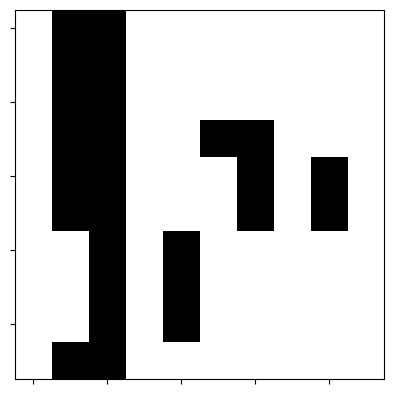

None


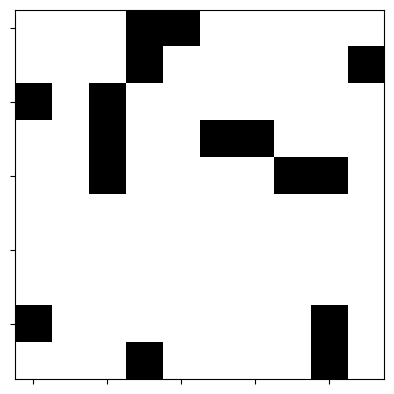

None


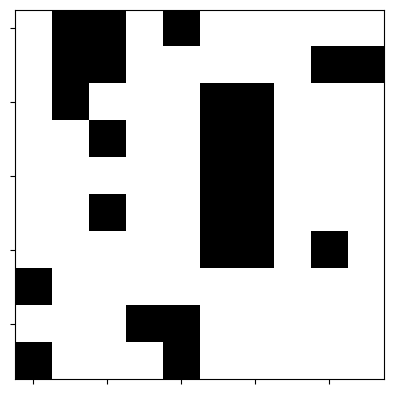

None


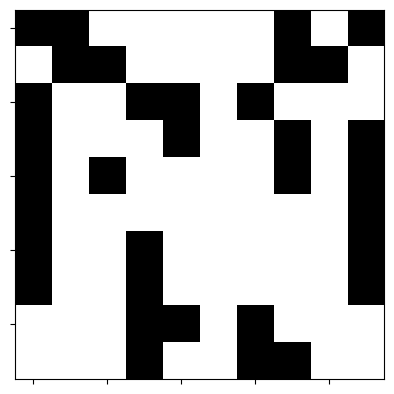

None


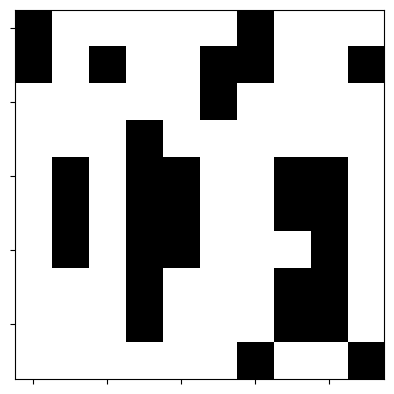

None


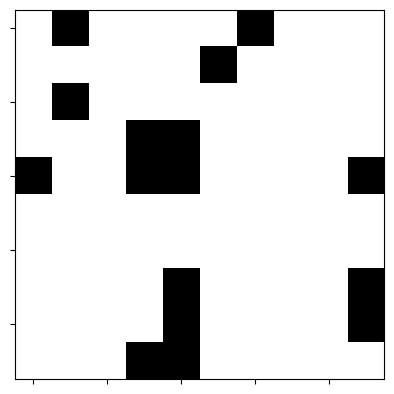

None


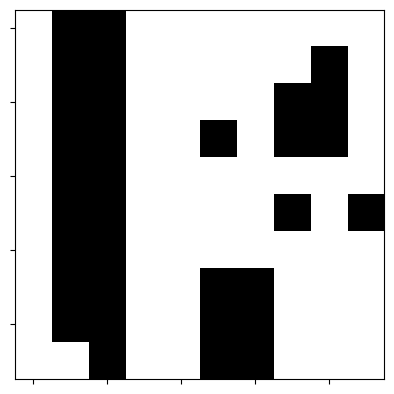

None


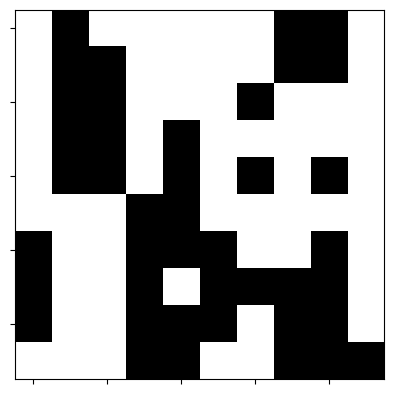

None


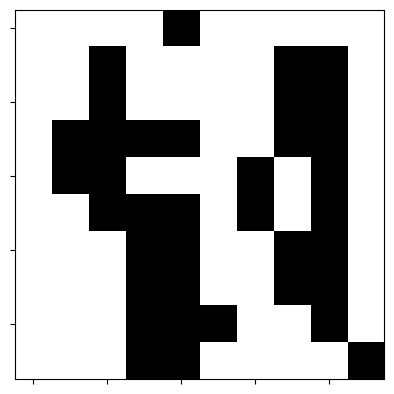

None


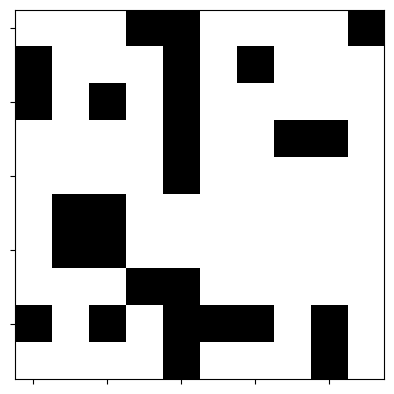

None


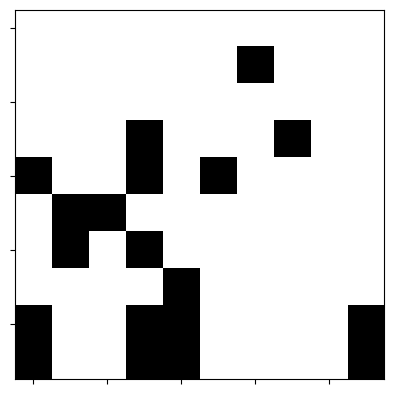

None


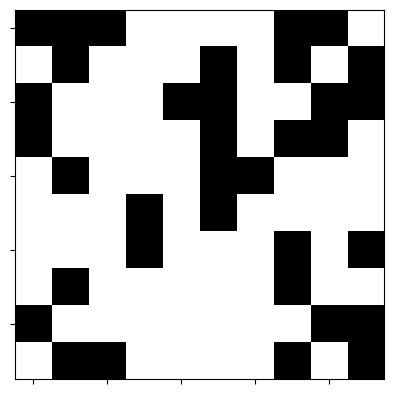

None


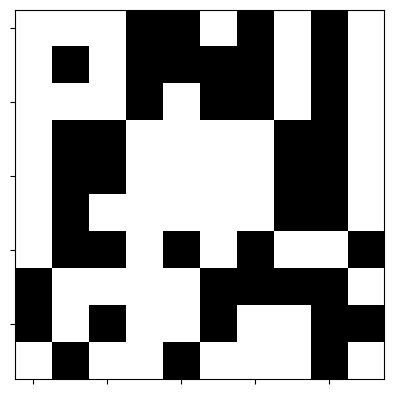

None


In [13]:
for config in configurations:
    print(arrayPlot(config))

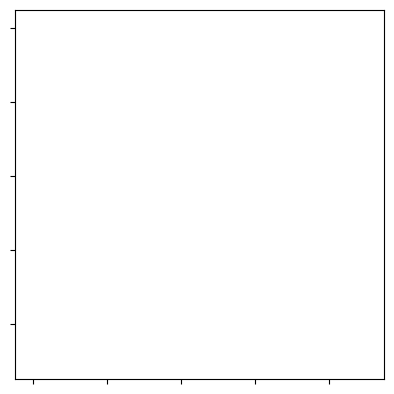

In [18]:
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')
fig, ax = plt.subplots()
images = runMCmovie(1.5,-1,0, MCstepPBC, ax, Stripes)
ani = animation.ArtistAnimation(fig, images, interval=1000/50, blit=True,repeat_delay=500)

In [19]:
ani